In [9]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class SimpleCNN(nn.Module):
    def __init__(self,n_classes,out_channels=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3,stride=1,padding=3, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=16, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=1352,out_features=n_classes)
        # self.fc = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x, get_features=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=1)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=1)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.avg_pool2d(x,kernel_size=2,stride=1)

        x = x.flatten(start_dim=1)
        x =self.fc1(x)
        # x = F.relu(x)
        # x = self.fc(x)
        x = F.softmax(x, dim=1)
        if get_features:
            return x, None
        return x


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()


def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    log_writer=None,
    verbose=True,
    eval_metrics=[accuracy],
):

    eval_metric_names = [eval_metric.__name__ for eval_metric in eval_metrics]

    history = {
        "train": {"loss": []},
        "valid": {"loss": []},
    }
    for eval_metric_name in eval_metric_names:
        history["train"][eval_metric_name] = []
        history["valid"][eval_metric_name] = []

    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = {eval_metric_name: 0 for eval_metric_name in eval_metric_names}
        total = 0
        evaluation_train = {
            "loss": 0,
            **{eval_metric_name: 0 for eval_metric_name in eval_metric_names},
        }

        for idx, data in enumerate(tqdm(train_loader, disable=not verbose)):
            input, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                correct[eval_metric_name] += eval_metric(output, labels) * len(labels)
            total += len(labels)

        for eval_metric_name in eval_metric_names:
            evaluation_train[eval_metric_name] = correct[eval_metric_name] / total

        evaluation_train["loss"] = Loss_epoch / total
        evaluation_valid, *_ = evaluate(
            model, valid_loader, criterion, device, eval_metrics=eval_metrics
        )
        if verbose:
            print(
                f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}"
            )

        for eval_metric_name in eval_metric_names:
            history["train"][eval_metric_name].append(
                evaluation_train[eval_metric_name]
            )
            history["valid"][eval_metric_name].append(
                evaluation_valid[eval_metric_name]
            )

        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])

        if log_writer is not None:
            log_dict = {}
            for eval_metric_name in eval_metric_names:
                log_dict.update(
                    {
                        f"train/train_{eval_metric_name}": (
                            evaluation_train[eval_metric_name],
                            epoch,
                        ),
                        f"val/valid_{eval_metric_name}": (
                            evaluation_valid[eval_metric_name],
                            epoch,
                        ),
                    }
                )

            log_dict.update(
                {
                    "train/train_loss": (evaluation_train["loss"], epoch),
                    "val/valid_loss": (evaluation_valid["loss"], epoch),
                }
            )
            log_writer.log(log_dict)

    return history


def evaluate(
    model,
    data_loader,
    criterion,
    device,
    eval_metrics=[accuracy],
    return_preds=False,
    return_features=False,
):
    model.eval()
    eval_metric_names = [eval_metric.__name__ for eval_metric in eval_metrics]
    metrics = {eval_metric_name: [] for eval_metric_name in eval_metric_names}
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[1].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                metrics[eval_metric_name].append(eval_metric(output, target))

            Loss_history.append(loss.item())
            if return_preds:

                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return (
        {
            **{
                eval_metric_name: torch.mean(
                    torch.Tensor(metrics[eval_metric_name])
                ).item()
                for eval_metric_name in eval_metric_names
            },
            "loss": torch.mean(torch.Tensor(Loss_history)).item(),
        },
        PREDS,
        features,
        ground_truth,
    )

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
)




def add_pr_curve_tensorboard(
    class_index, classes, test_probs, test_label, writer, global_step=0
):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(
        classes[class_index],
        tensorboard_truth,
        tensorboard_probs,
        global_step=global_step,
    )


def acc_pr_rec(preds, labels, classes, writer, global_step=0):
    preds = np.array(preds)
    labels = np.array(labels)
    preds_ = np.argmax(preds, axis=1)
    for i in range(len(classes)):
        add_pr_curve_tensorboard(i, classes, preds, labels, writer, global_step)
    writer.add_scalar(
        "Accuracy", ac := accuracy_score(labels, preds_), global_step=global_step
    )
    writer.add_scalar(
        "Precision",
        pr := precision_score(labels, preds_, average="weighted"),
        global_step=global_step,
    )
    writer.add_scalar(
        "Recall",
        rec := recall_score(labels, preds_, average="weighted"),
        global_step=global_step,
    )
    writer.add_scalar(
        "F1",
        f1 := f1_score(labels, preds_, average="weighted"),
        global_step=global_step,
    )
    writer.close()
    return ac, pr, rec, f1


def plot_ConfusionMatrix(preds, labels, classes, title, writer, global_step=0):
    cm = confusion_matrix(labels, np.argmax(preds, axis=1), normalize="true")
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    plt.title(f"Model: {title}")
    plt.show()
    writer.add_figure("ConfusionMatrix", fig, global_step=global_step)
    writer.close()
    return cm

In [12]:
from torchvision.datasets import USPS
from torchvision.transforms import v2 as tt
from torch.utils.data import Dataset, DataLoader
root_dir = r"C:\Users\KHADGA JYOTH ALLI\Desktop\programming\datasets"
dataset_train = USPS(root=root_dir, train=True, download=True, transform=tt.ToTensor())
dataset_test = USPS(root=root_dir, train=False, download=True, transform=tt.ToTensor())


c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [13]:
classes  = np.unique(dataset_train.targets).astype(str).tolist()

In [14]:
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [15]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


out_channels: 8


  0%|          | 0/228 [00:00<?, ?it/s]

100%|██████████| 228/228 [00:02<00:00, 97.78it/s] 


epoch: 0, train: {'loss': 1.9545015680202975, 'accuracy': 0.5043203950811195}, valid: {'accuracy': 0.5980633497238159, 'loss': 1.8601045608520508}


c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test accuracy: 0.5984055804683608, test loss: 1.8597495555877686
Precision: 0.40081087506533025, Recall: 0.5984055804683608, F1: 0.47449619854186664
--------------------


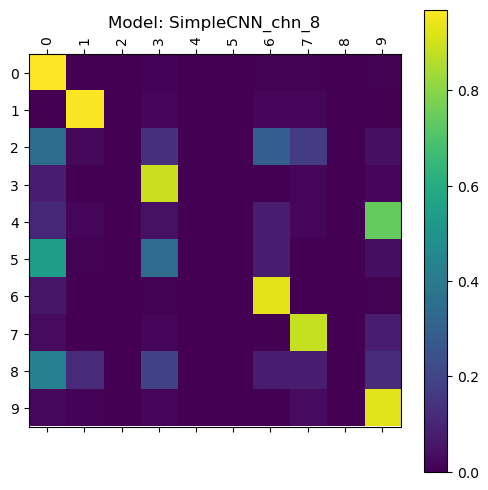

Average Accuracy: 0.5984055804683608, Average Loss: 1.8597495555877686, Average Precision: 0.40081087506533025, Average Recall: 0.5984055804683608
out_channels: 16


100%|██████████| 228/228 [00:02<00:00, 105.17it/s]


epoch: 0, train: {'loss': 1.8213436532749787, 'accuracy': 0.6390069949743009}, valid: {'accuracy': 0.6794988512992859, 'loss': 1.7806648015975952}


c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test accuracy: 0.6796213253612357, test loss: 1.780538558959961
Precision: 0.5208498965597463, Recall: 0.6796213253612357, F1: 0.5858121296335788
--------------------


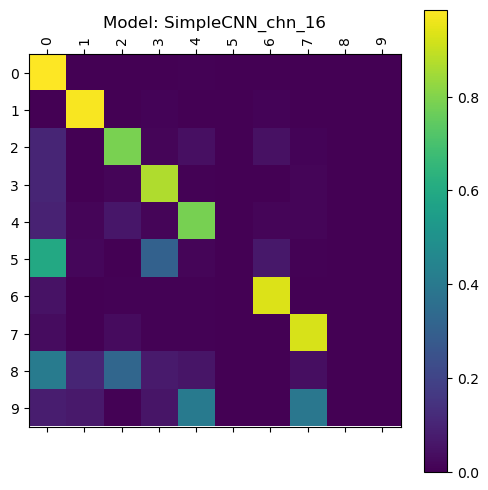

Average Accuracy: 1.2780269058295963, Average Loss: 3.6402881145477295, Average Precision: 0.9216607716250766, Average Recall: 1.2780269058295963
out_channels: 32


100%|██████████| 228/228 [00:02<00:00, 105.79it/s]


epoch: 0, train: {'loss': 1.8860067829087084, 'accuracy': 0.5715265395039313}, valid: {'accuracy': 0.6214631199836731, 'loss': 1.8385117053985596}


c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test accuracy: 0.6213253612356752, test loss: 1.8386163711547852
Precision: 0.43169592315549393, Recall: 0.6213253612356752, F1: 0.5041598340309588
--------------------


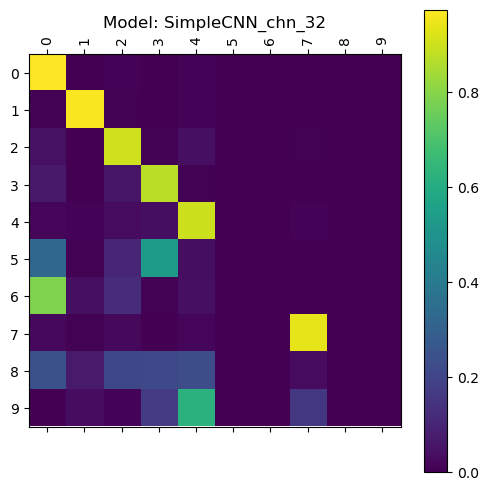

Average Accuracy: 1.8993522670652716, Average Loss: 5.478904485702515, Average Precision: 1.3533566947805706, Average Recall: 1.8993522670652716
out_channels: 64


100%|██████████| 228/228 [00:02<00:00, 102.41it/s]


epoch: 0, train: {'loss': 1.97208283835683, 'accuracy': 0.48690165962935505}, valid: {'accuracy': 0.6604554653167725, 'loss': 1.8006221055984497}


c:\Users\KHADGA JYOTH ALLI\.conda\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test accuracy: 0.6606875934230194, test loss: 1.8004103899002075
Precision: 0.5303323068448162, Recall: 0.6606875934230194, F1: 0.5783085348281775
--------------------


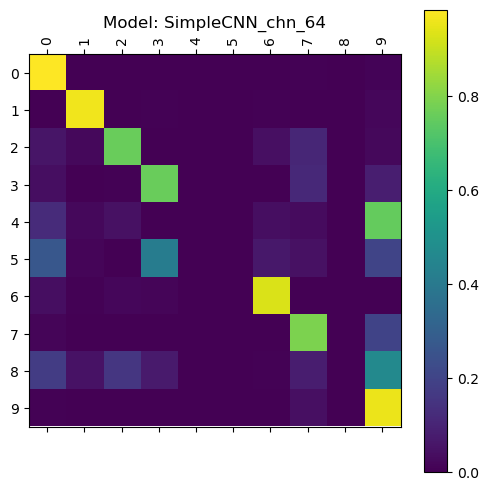

Average Accuracy: 2.560039860488291, Average Loss: 7.279314875602722, Average Precision: 1.8836890016253869, Average Recall: 2.560039860488291


In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter

from sklearn.manifold import TSNE

class custom_summary_writer:
    def __init__(self, writer):
        self.writer = writer

    def log(self, metrics):
        for key, value in metrics.items():
            self.writer.add_scalar(key, *(value))


n_splits = 1
# kFold = KFold(n_splits=n_splits, random_state=42, shuffle=True)
Avg_Accuracy = 0
Avg_Loss = 0
Avg_Precision = 0
Avg_Recall = 0



for out_channels in [8, 16, 32, 64]:
    print(f"out_channels: {out_channels}")
    title  = f"SimpleCNN_chn_{out_channels}"
    writer = custom_summary_writer(SummaryWriter(f"runs/USPS/{title}"))

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model = SimpleCNN(len(classes))
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    history = train(
        model,
        train_loader,
        test_loader,
        optimizer,
        criterion,
        device,
        epochs=1,
        log_writer=writer,
        verbose=True,
        eval_metrics=[accuracy],
    )

    evaluation_test,test_preds, _, test_labels  = evaluate(
                model, test_loader, criterion, device, eval_metrics=[accuracy], return_preds=True
            )

    loss_test = criterion(torch.tensor(test_preds), torch.tensor(test_labels)).item()
    ac, pr, rec, f1 = acc_pr_rec(test_preds, test_labels, classes, writer.writer)


    print(f"test accuracy: {ac}, test loss: {loss_test}")
    print(f"Precision: {pr}, Recall: {rec}, F1: {f1}")
    print("-" * 20)
    Avg_Accuracy += ac
    Avg_Loss += loss_test
    Avg_Precision += pr
    Avg_Recall += rec

    cm = plot_ConfusionMatrix(test_preds, test_labels, classes, title, writer.writer)

    writer.writer.close()
    print(
    f"Average Accuracy: {Avg_Accuracy/n_splits}, Average Loss: {Avg_Loss/n_splits}, Average Precision: {Avg_Precision/n_splits}, Average Recall: {Avg_Recall/n_splits}"
    )